In [141]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [142]:
def load_data(file_path):
    data = pd.read_csv(file_path, index_col=0, parse_dates=True)
    print(data.head())  # Print the first few rows to inspect the data
    print(data.index)   # Print the index to check its type and format

    # Convert timezone-aware datetime to naive datetime
    if data.index.tz is not None:
        data.index = data.index.tz_localize(None)

    # Convert datetime to date-only
    data.index = pd.to_datetime(data.index).normalize()  # Normalize to remove time part, keep only date

    # Filter data within the specified date range
    start_date = pd.to_datetime('2012-01-01')
    end_date = pd.to_datetime('2020-12-31')
    data = data[(data.index >= start_date) & (data.index <= end_date)]
    
    return data

In [143]:
# Prepare data for LSTM
def prepare_data(data, look_back=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i])
        y.append(scaled_data[i, 0])  # Predicting the 'Close' price
    
    return np.array(X), np.array(y), scaler


In [144]:
# Build LSTM model
def build_model(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(units=50, return_sequences=True),
        Dropout(0.2),
        LSTM(units=50),
        Dropout(0.2),
        Dense(units=1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

In [145]:

# Train model
def train_model(model, X_train, y_train, epochs=10, batch_size=32, validation_split=0.2):
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        shuffle=False
    )
    return history

In [146]:
# Make predictions
def make_predictions(model, X_test, scaler):
    predictions = model.predict(X_test)
    return scaler.inverse_transform(predictions)

# Evaluate model
def evaluate_model(y_true, y_pred):
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    return mse, rmse, mae

# Plot results
def plot_results(y_true, y_pred):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title('LSTM Model: Actual vs Predicted Stock Prices')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

In [147]:
# # Main function

#     # Load data
file_path = 'NVDA_data_with_metrics.csv'  # Replace with your CSV file name
dataCSV = pd.read_csv(file_path)
    
print(dataCSV.shape)
# Select features for training
features = ['Close','P/E Ratio', 'P/B Ratio', 'Dividend Yield', 'Dividend Payout Ratio', #4
            'ROE', 'ROA', 'Beta', 'Market Capitalization', 'Revenue Growth', #5
            'Debt-to-Equity Ratio', 'Free Cash Flow', 'Current Ratio', 'Quick Ratio', #4
            'PEG Ratio', 'Standard Deviation', 'Value at Risk (VaR)', 'Sharpe Ratio', #4
            'Sortino Ratio', 'Maximum Drawdown', 'Downside Deviation', 'Tracking Error', #4 
            'R-squared', 'Treynor Ratio', 'Information Ratio', 'Conditional Value at Risk (CVaR)', #4
            'Beta-adjusted Sharpe Ratio', 'Drawdown Duration', 'Ulcer Index', 'Jensens Alpha']#4
    
data = dataCSV[features]
datesRev=dataCSV['Date']
print(datesRev)

# Convert 'Date' column to UTC or remove timezone
datesRev = pd.to_datetime(dataCSV['Date'], utc=True)  # Converts to UTC

# If you prefer to remove the timezone info
# datesRev = pd.to_datetime(dataCSV['Date']).dt.tz_convert(None)

# Optionally set the 'Date' column as the index
dataCSV.set_index(datesRev, inplace=True)

# Now 'datesRev' contains the dates in datetime format without timezone issues
print(datesRev.head())  # To check the first few dates




(3142, 37)
0       2012-01-03 00:00:00-05:00
1       2012-01-04 00:00:00-05:00
2       2012-01-05 00:00:00-05:00
3       2012-01-06 00:00:00-05:00
4       2012-01-09 00:00:00-05:00
                  ...            
3137    2024-06-24 00:00:00-04:00
3138    2024-06-25 00:00:00-04:00
3139    2024-06-26 00:00:00-04:00
3140    2024-06-27 00:00:00-04:00
3141    2024-06-28 00:00:00-04:00
Name: Date, Length: 3142, dtype: object
0   2012-01-03 05:00:00+00:00
1   2012-01-04 05:00:00+00:00
2   2012-01-05 05:00:00+00:00
3   2012-01-06 05:00:00+00:00
4   2012-01-09 05:00:00+00:00
Name: Date, dtype: datetime64[ns, UTC]


In [148]:
def prepare_data(data, look_back=45):
    X, y, dates = [], [], []
    for i in range(len(data) - look_back):
        X.append(data.iloc[i:(i + look_back)].values)
        y.append(data['Close'].iloc[i + look_back])
        dates.append(data.index[i + look_back])
    return np.array(X), np.array(y), np.array(dates)

# Prepare your data
data['Close'] = data['Close'].shift(-1)  # Shift Close price to predict next day's price
data = data.dropna()  # Remove any rows with NaN values
X, y, dates = prepare_data(data)

# Split the data
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
dates_train, dates_test = dates[:split], dates[split:]

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))

/var/folders/83/3t5wk1pn2fq83ss49zg61zf40000gn/T/ipykernel_88545/1800316055.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Close'] = data['Close'].shift(-1)  # Shift Close price to predict next day's price


In [149]:

datesRev


0      2012-01-03 05:00:00+00:00
1      2012-01-04 05:00:00+00:00
2      2012-01-05 05:00:00+00:00
3      2012-01-06 05:00:00+00:00
4      2012-01-09 05:00:00+00:00
                  ...           
3137   2024-06-24 04:00:00+00:00
3138   2024-06-25 04:00:00+00:00
3139   2024-06-26 04:00:00+00:00
3140   2024-06-27 04:00:00+00:00
3141   2024-06-28 04:00:00+00:00
Name: Date, Length: 3142, dtype: datetime64[ns, UTC]

In [150]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Build the model
model = build_model((X_train_scaled.shape[1], X_train_scaled.shape[2]))

/Users/tanishkyadav/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [151]:
# Train the model
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    shuffle=False
)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 8.4168e-05 - val_loss: 0.0819
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0017 - val_loss: 0.0987
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0018 - val_loss: 0.1013
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0020 - val_loss: 0.1007
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0022 - val_loss: 0.0767
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0026 - val_loss: 0.0674
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0037 - val_loss: 0.0736
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0031 - val_loss: 0.0468
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0036 - val_loss: 0.0433
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0024 - val_loss: 0.0238
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0019 - val_loss: 0.0082
Epoch 12/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
MSE: 605.0972
RMSE: 24.5987
MAE: 15.8413


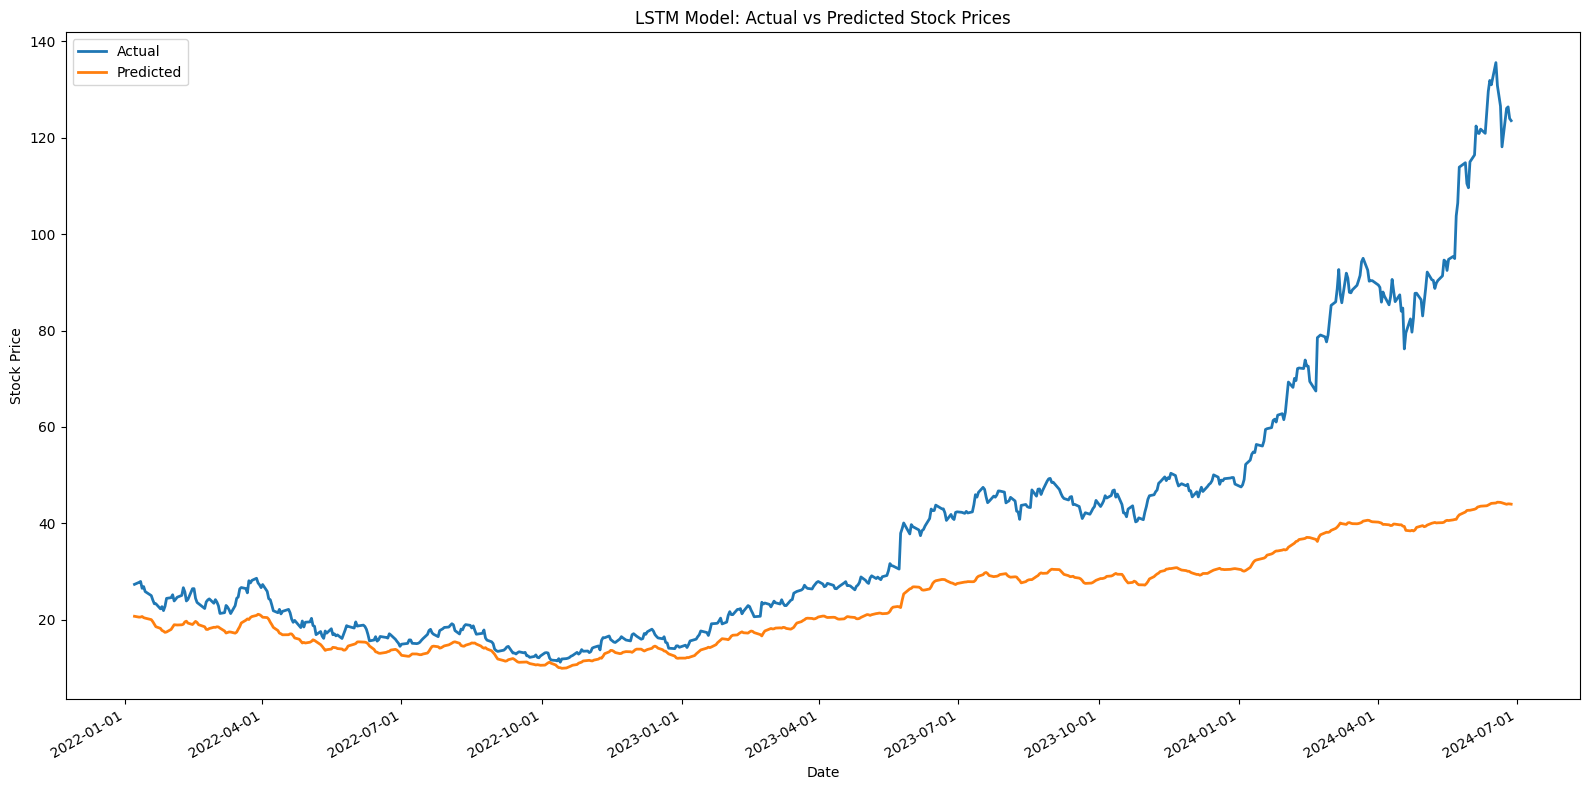

In [152]:
# Assuming datesRev is aligned with your original data
# Map the integer indices of dates_test back to datesRev
dates_test = datesRev[dates.astype(int)][split:]  # Get dates corresponding to test indices

# Now, dates_test contains the actual dates for the test period.

# Make predictions
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Plot results
plt.figure(figsize=(16, 8))
plt.plot(dates_test, y_test, label='Actual', linewidth=2)
plt.plot(dates_test, y_pred, label='Predicted', linewidth=2)
plt.title('LSTM Model: Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

# Format x-axis to show dates nicely
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels

plt.tight_layout()
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MSE: 605.0972
RMSE: 24.5987
MAE: 15.8413
Date range: 2022-01-07 05:00:00+00:00 to 2024-06-27 04:00:00+00:00


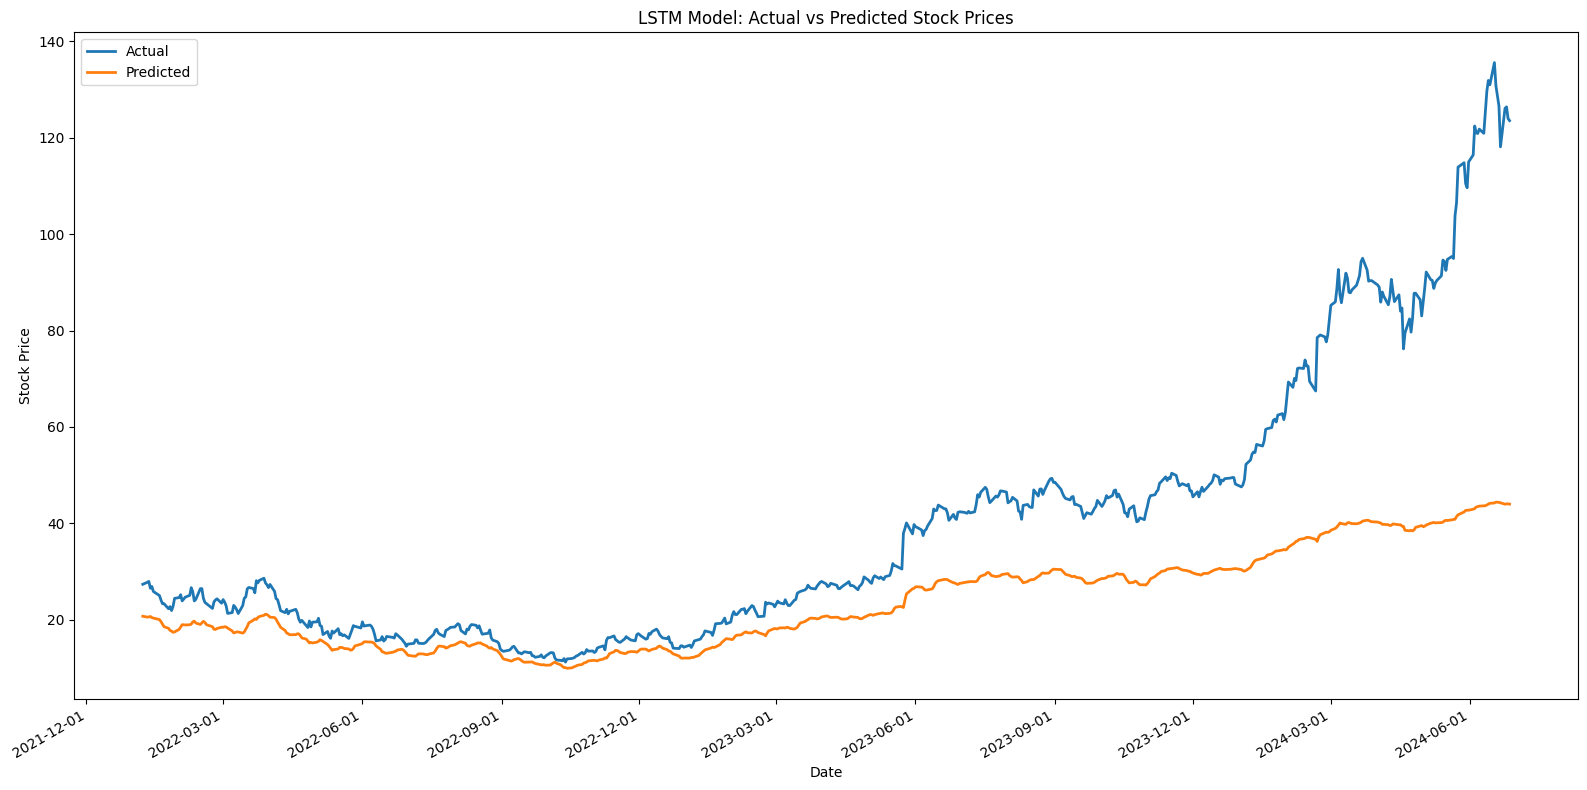

In [153]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Make predictions
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Ensure dates_test is a pandas DatetimeIndex
dates_test = pd.to_datetime(dates_test)

print(f"Date range: {dates_test.min()} to {dates_test.max()}")

# Plot results
plt.figure(figsize=(16, 8))
plt.plot(dates_test, y_test, label='Actual', linewidth=2)
plt.plot(dates_test, y_pred, label='Predicted', linewidth=2)
plt.title('LSTM Model: Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

# Format x-axis to show dates nicely
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels

plt.tight_layout()
plt.show()

In [154]:
data.index = pd.to_datetime(data.index)